In [13]:
import os 
import pandas as pd
import numpy as np
import optuna
import lightgbm

C:\Users\Foosh\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\Foosh\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\Foosh\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
os.listdir('data')

['Raw',
 'steam_spy_clean.csv',
 'steam_spy_tag_data.csv',
 'steam_store_dlc_clean.csv',
 'steam_store_games_clean.csv']

In [16]:
spy_clean = pd.read_csv(os.path.join('data', 'steam_spy_clean.csv'))
spy_tag = pd.read_csv(os.path.join('data', 'steam_spy_tag_data.csv'))
store_dlc = pd.read_csv(os.path.join('data', 'steam_store_dlc_clean.csv'), index_col = 0)
store_games = pd.read_csv(os.path.join('data', 'steam_store_games_clean.csv'), index_col = 0)

<ipython-input-16-b32d3b599816>:3: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  store_dlc = pd.read_csv(os.path.join('data', 'steam_store_dlc_clean.csv'), index_col = 0)


In [17]:
print(spy_clean.isnull().any().any())
print(spy_tag.isnull().any().any())
print(store_dlc.isnull().any().any())
print(store_games.isnull().any().any())

False
False
True
True


In [18]:
print(spy_clean.shape)
spy_clean.head()

(74053, 12)


,appid,name,positive,negative,owners,average_forever,median_forever,price,initialprice,languages,genre,tags
0,1433210,Notebook Artillery,10,0,0-20000,0,0,499.0,499.0,['English'],['Indie'],"['Hand-drawn', '2D', 'Arcade']"
1,1433240,Whiskey Island,1,1,0-20000,0,0,1699.0,1699.0,['English'],"['Casual', ' Indie', ' Early Access']","['Casual', 'Open World', 'Management']"
2,1433320,Mortal Decay,61,2,0-20000,0,0,299.0,299.0,"['English', ' Portuguese - Portugal']","['Action', ' Adventure', ' Indie']","['Horror', 'First-Person', 'Survival Horror']"
3,1433340,Happy's Humble Burger Farm,1009,75,0-20000,0,0,1999.0,1999.0,"['English', ' French', ' Italian', ' German', ...","['Action', ' Adventure', ' Indie', ' Simulation']","['Horror', 'First-Person', 'Atmospheric']"
4,1433390,To My Best Friend,4,0,0-20000,0,0,499.0,499.0,"['English', ' French', ' Spanish - Spain']",['Indie'],"['Story Rich', 'Walking Simulator', 'Emotional']"


In [19]:
print(spy_tag.shape)
spy_tag.head()

(114902, 451)


,appid,1980s,1990s,2.5d,2d,2d_fighter,2d_platformer,360_video,3d,3d_fighter,...,well_written,werewolves,western,wholesome,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
0,1433210,112,0,0,196,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1433240,0,0,0,0,0,0,0,37,0,...,0,0,0,0,0,0,0,0,0,0
2,1433260,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1433310,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1433320,0,0,0,0,0,0,0,110,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
print(store_games.shape)
store_games.head()

(61243, 19)


,type,name,steam_appid,required_age,is_free,dlc,developers,publishers,categories,release_date,controller_support,windows,mac,linux,metacritic_score,metacritic_url,initial,final,discount_percent
0,game,Dota 2,570,0,True,"[1241930, 652720]",['Valve'],['Valve'],"['Multi-player', 'Co-op', 'Steam Trading Cards...",2013-07-09,0,1,1,1,90.0,https://www.metacritic.com/game/pc/dota-2?ftag...,NaN,NaN,NaN
2,game,Apex Legends™,1172470,0,True,[],['Respawn Entertainment'],['Electronic Arts'],"['Multi-player', 'PvP', 'Online PvP', 'Co-op',...",2020-11-04,1,1,0,0,88.0,https://www.metacritic.com/game/pc/apex-legend...,NaN,NaN,NaN
3,game,PUBG: BATTLEGROUNDS,578080,0,True,[],"['KRAFTON, Inc.']","['KRAFTON, Inc.']","['Multi-player', 'PvP', 'Online PvP', 'Stats',...",2017-12-21,0,1,0,0,NaN,NaN,NaN,NaN,NaN
4,game,New World,1063730,0,False,[],['Amazon Games'],['Amazon Games'],"['Multi-player', 'MMO', 'PvP', 'Online PvP', '...",2021-09-28,0,1,0,0,70.0,https://www.metacritic.com/game/pc/new-world?f...,2505.692288,1252.846144,50.0
5,game,Team Fortress 2,440,0,True,[629330],['Valve'],['Valve'],"['Multi-player', 'Cross-Platform Multiplayer',...",2007-10-10,0,1,1,1,92.0,https://www.metacritic.com/game/pc/team-fortre...,NaN,NaN,NaN


In [24]:
store_games[store_games.isnull().any(axis = 1)]

,type,name,steam_appid,required_age,is_free,dlc,developers,publishers,categories,release_date,controller_support,windows,mac,linux,metacritic_score,metacritic_url,initial,final,discount_percent
0,game,Dota 2,570,0,True,"[1241930, 652720]",['Valve'],['Valve'],"['Multi-player', 'Co-op', 'Steam Trading Cards...",2013-07-09,0,1,1,1,90.0,https://www.metacritic.com/game/pc/dota-2?ftag...,NaN,NaN,NaN
2,game,Apex Legends™,1172470,0,True,[],['Respawn Entertainment'],['Electronic Arts'],"['Multi-player', 'PvP', 'Online PvP', 'Co-op',...",2020-11-04,1,1,0,0,88.0,https://www.metacritic.com/game/pc/apex-legend...,NaN,NaN,NaN
3,game,PUBG: BATTLEGROUNDS,578080,0,True,[],"['KRAFTON, Inc.']","['KRAFTON, Inc.']","['Multi-player', 'PvP', 'Online PvP', 'Stats',...",2017-12-21,0,1,0,0,NaN,NaN,NaN,NaN,NaN
5,game,Team Fortress 2,440,0,True,[629330],['Valve'],['Valve'],"['Multi-player', 'Cross-Platform Multiplayer',...",2007-10-10,0,1,1,1,92.0,https://www.metacritic.com/game/pc/team-fortre...,NaN,NaN,NaN
6,game,Grand Theft Auto V,271590,0,False,[771300],['Rockstar North'],['Rockstar Games'],"['Single-player', 'Multi-player', 'PvP', 'Onli...",2015-04-13,1,1,0,0,96.0,https://www.metacritic.com/game/pc/grand-theft...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61617,game,BoyAndLabyrinth,789710,0,False,[],['WBTgame'],['WBTgame'],"['Single-player', 'Steam Achievements', 'Steam...",2018-03-26,0,1,0,0,NaN,NaN,400.379440,400.379440,0.0
61618,game,Hidden Cubes,729290,0,False,[],['NixieCraft'],['NixieCraft'],"['Single-player', 'Steam Achievements', 'Steam...",2018-02-07,0,1,1,1,NaN,NaN,492.277945,492.277945,0.0
61621,game,Simian Rising,848400,0,False,[],['All Caps Industries'],['All Caps Industries'],['Single-player'],2018-06-13,0,1,0,0,NaN,NaN,973.407167,973.407167,0.0
61638,game,Yoke Light,858730,0,False,[],['Kotoshiro'],['Kotoshiro'],['Single-player'],2018-06-28,0,1,0,0,NaN,NaN,80.483229,80.483229,0.0


In [29]:
merged = store_games.merge(spy_clean, how = 'inner', left_on = 'steam_appid', right_on = 'appid')

In [31]:
merged.drop(['type', 'name_x', 'name_y', 'dlc'], axis = 1, inplace = True)

In [34]:
print(list(merged.columns))

['steam_appid', 'required_age', 'is_free', 'developers', 'publishers', 'categories', 'release_date', 'controller_support', 'windows', 'mac', 'linux', 'metacritic_score', 'metacritic_url', 'initial', 'final', 'discount_percent', 'appid', 'positive', 'negative', 'owners', 'average_forever', 'median_forever', 'price', 'initialprice', 'languages', 'genre', 'tags']


In [56]:
subset = merged[['categories', 'positive', 'negative', 'owners', 'average_forever', 'median_forever','genre', 'tags', 'price']].copy()

In [57]:
subset['categories'] = subset['categories'].apply(lambda x: len(eval(x)))
subset['genre'] = subset['genre'].apply(lambda x: len(eval(x)))
subset['tags'] = subset['tags'].apply(lambda x: len(eval(x)))
subset['owners'] = subset['owners'].apply(lambda x: int(x.split('-')[0]))

In [62]:
subset.head()

,categories,positive,negative,owners,average_forever,median_forever,genre,tags,price
0,7,1607914,337779,200000000,40686,897,3,3,0.0
1,9,510084,104286,50000000,7380,743,3,3,0.0
2,6,1228783,924298,50000000,22786,6637,4,3,0.0
3,8,176134,75910,50000000,7834,2978,4,3,3999.0
4,14,881554,58658,50000000,10279,399,2,3,0.0


In [80]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("tab10")
subset_scaled = StandardScaler().fit_transform(subset)


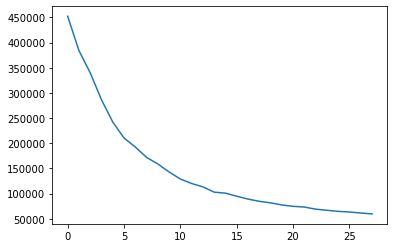

In [68]:
clusters = [i for i in range(2, 30)]
errors = []

for k in clusters:
    kmeans = KMeans(n_clusters=k)
    fit_kmeans = kmeans.fit(subset_scaled)
    errors.append(fit_kmeans.inertia_)
    
plt.plot(errors)

In [97]:
kmeans = KMeans(n_clusters = 7)
fit_kmeans = kmeans.fit(subset_scaled)
subset['cluster'] = fit_kmeans.labels_

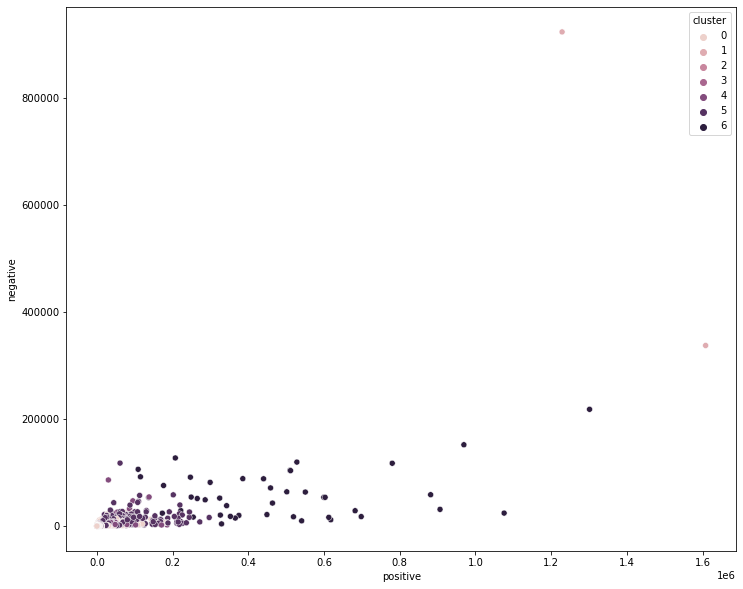

In [98]:
plt.figure(figsize = (12, 10))

sns.scatterplot(data = subset, x = 'positive', y='negative', hue = 'cluster')

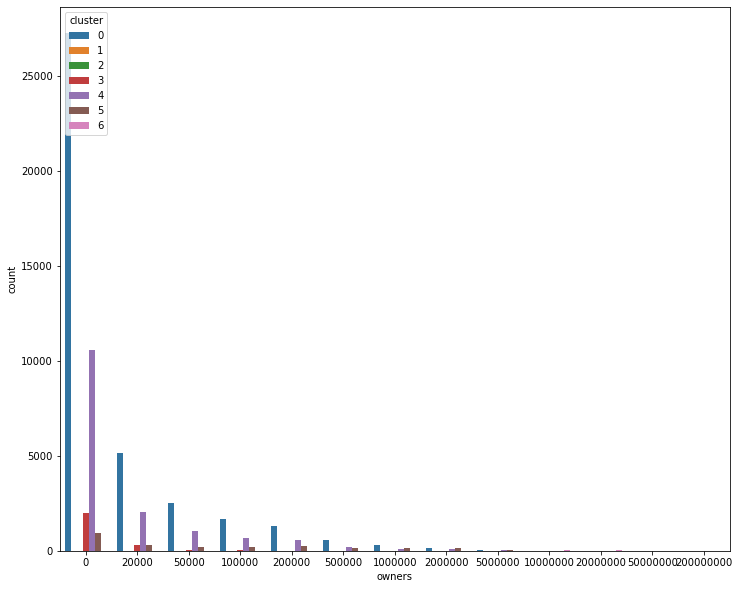

In [101]:
plt.figure(figsize = (12, 10))
sns.countplot(data = subset, x = 'owners',hue = 'cluster')

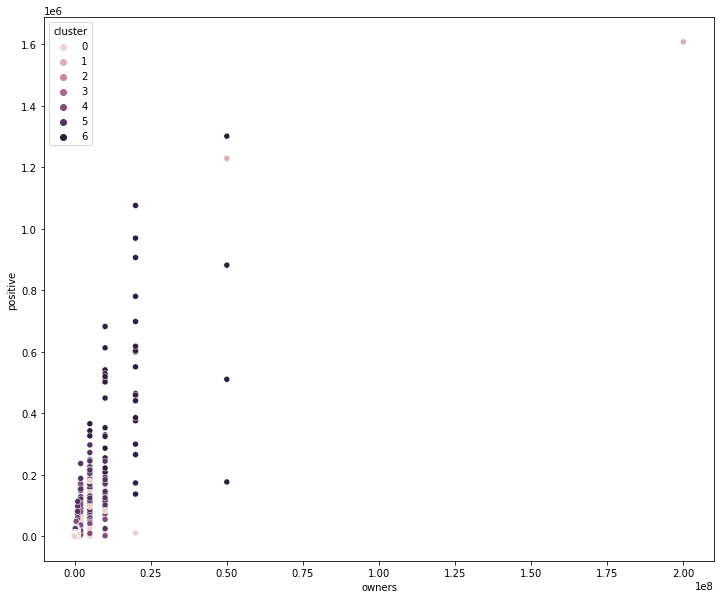

In [103]:
plt.figure(figsize = (12, 10))
sns.scatterplot(data = subset, x = 'owners', y = 'positive', hue = 'cluster')

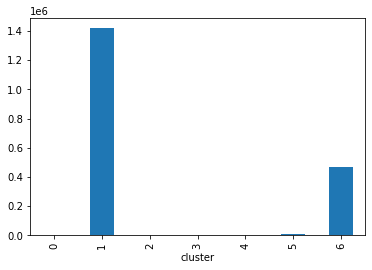

In [106]:

subset.groupby('cluster')['positive'].mean().plot(kind = 'bar')

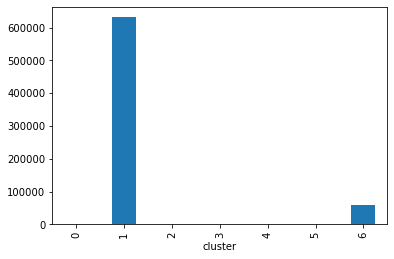

In [107]:
subset.groupby('cluster')['negative'].mean().plot(kind = 'bar')


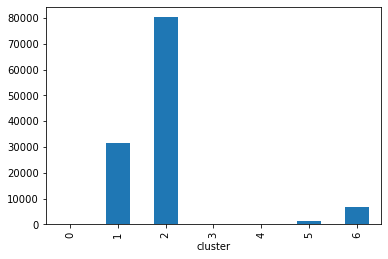

In [110]:
subset.groupby('cluster')['average_forever'].mean().plot(kind = 'bar')

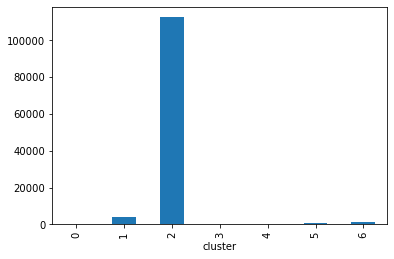

In [111]:
subset.groupby('cluster')['median_forever'].mean().plot(kind = 'bar')

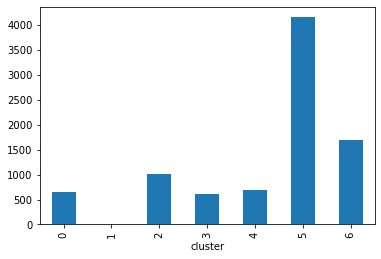

In [112]:
subset.groupby('cluster')['price'].mean().plot(kind = 'bar')
